In [1]:
!pip install kaggle

**download dataset**

In [25]:
#unzipping the files 
#import zipfile

#with zipfile.ZipFile("rock-paper-scissors.zip", "r") as zip_ref:
#    zip_ref.extractall("rock-paper-scissors")

Verifying folder structure

In [26]:
import os
print(os.listdir("rock-paper-scissors/train"))
print(os.listdir("rock-paper-scissors/test"))

['train']
['test']


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from PIL import Image
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import precision_score, recall_score, f1_score


from keras import datasets, layers, models
from keras.utils import to_categorical

import random
import tensorflow as tf


2025-07-29 19:50:24.939534: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-29 19:50:24.953353: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-29 19:50:25.062899: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-29 19:50:25.190858: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753836625.282952    1175 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753836625.30

In [2]:
df_train = pd.read_csv("rock-paper-scissors/train/train/_annotations.csv")
df_test = pd.read_csv("rock-paper-scissors/test/test/_annotations.csv")

In [47]:
print(df_train.head())


                                            filename  width  height  class  \
0  egohands-public-1620914960773_png_jpg.rf.aa184...    640     640   Rock   
1  egohands-public-1624053434391_png_jpg.rf.aaef5...    640     640  Paper   
2  egohands-public-1624465902684_png_jpg.rf.aaa09...    640     640   Rock   
3  Screen-Shot-2022-02-08-at-12-59-24-PM_png.rf.a...    640     640   Rock   
4  egohands-public-1622127402076_png_jpg.rf.aa897...    640     640   Rock   

   xmin  ymin  xmax  ymax  
0   429   185   562   319  
1   269   354   544   443  
2   427   332   551   509  
3    80   268   145   395  
4    83   128   296   381  


In [48]:
print(df_train.columns)


Index(['filename', 'width', 'height', 'class', 'xmin', 'ymin', 'xmax', 'ymax'], dtype='object')


In [49]:
print(df_train['class'].unique())

['Rock' 'Paper' 'Scissors']


In [65]:
print("Train shape:", df_train.shape)  # (rows, columns)
print("Test shape:", df_test.shape)

Train shape: (4610, 10)
Test shape: (204, 10)


Filtering out corrupted Images in train folder

In [3]:
import os

def is_image_valid(path):
    try:
        with Image.open(path) as img:
            img.verify()
        return True
    except Exception:
        return False

# If filenames are relative, prepend the directory path
img_dir = "rock-paper-scissors/train/train/"
df_train['full_path'] = df_train['filename'].apply(lambda x: os.path.join(img_dir, x))

df_train['is_valid'] = df_train['full_path'].apply(is_image_valid)

# Filter out corrupted images
df_train_clean = df_train[df_train['is_valid']].reset_index(drop=True)

Checking results

In [4]:
print("Before filtering:", len(df_train))
print("After filtering:", len(df_train_clean))

Before filtering: 4610
After filtering: 4610


In [5]:
test_img_dir = "rock-paper-scissors/test/test/"  # Adjust if needed
df_test['full_path'] = df_test['filename'].apply(lambda x: os.path.join(test_img_dir, x))

In [6]:
# checking if each image is valid

from PIL import Image

def is_image_valid(path):
    try:
        with Image.open(path) as img:
            img.verify()
        return True
    except Exception:
        return False

df_test['is_valid'] = df_test['full_path'].apply(is_image_valid)


In [7]:
# filtering for bad imaages
df_test_clean = df_test[df_test['is_valid']].reset_index(drop=True)


In [8]:
#fact checking
print("Original test set:", len(df_test))
print("Filtered test set:", len(df_test_clean))


Original test set: 204
Filtered test set: 204


**Creating a smaller subset for training and testing**

In [9]:
import pandas as pd

def subsample(df, n_per_class=100):
    return df.groupby('class').apply(lambda x: x.sample(min(len(x), n_per_class), random_state=42)).reset_index(drop=True)

train_subset = subsample(df_train_clean, n_per_class=100)
test_subset = subsample(df_test_clean, n_per_class=100)


/tmp/ipykernel_1175/2598175619.py:4: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return df.groupby('class').apply(lambda x: x.sample(min(len(x), n_per_class), random_state=42)).reset_index(drop=True)
/tmp/ipykernel_1175/2598175619.py:4: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return df.groupby('class').apply(lambda x: x.sample(min(len(x), n_per_class), random_state=42)).reset_index(drop=True)


**Creating mapping**

In [10]:
class_names = ['Rock', 'Paper', 'Scissors']
class_to_idx = {cls_name: idx for idx, cls_name in enumerate(class_names)}

Custom dataset class

In [11]:
import torch
from torch.utils.data import Dataset
from PIL import Image
import os

class RockPaperScissorsDataset(Dataset):
    def __init__(self, dataframe, img_dir, transform=None):
        self.dataframe = dataframe
        self.img_dir = img_dir
        self.transform = transform
        self.class_to_idx = class_to_idx  # From step 1

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        img_path = os.path.join(self.img_dir, row['filename'])
        image = Image.open(img_path).convert("RGB")
        label = self.class_to_idx[row['class']]  # Map class to index
        if self.transform:
            image = self.transform(image)
        return image, label


Setting up transforms 

In [12]:
from torchvision import transforms

transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224 (common for pretrained models)
    transforms.ToTensor(),          # Convert to Tensor
    # You can add normalization here if needed
])


Creating dataset

In [13]:
from torch.utils.data import DataLoader

img_dir = "rock-paper-scissors/train/train/"  
dataset = RockPaperScissorsDataset(dataframe=df_train_clean, img_dir=img_dir, transform=transform)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)


**Visualizing Images**

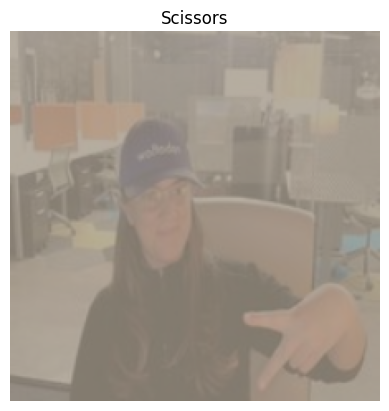

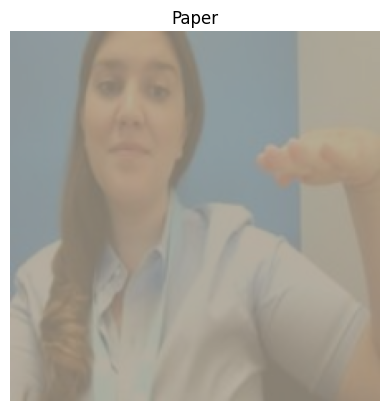

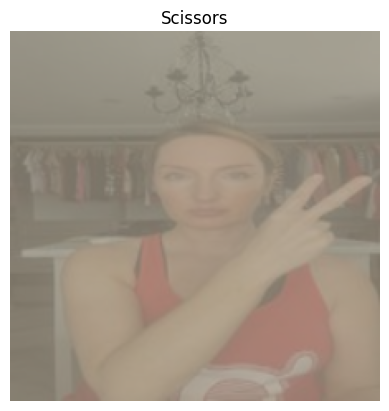

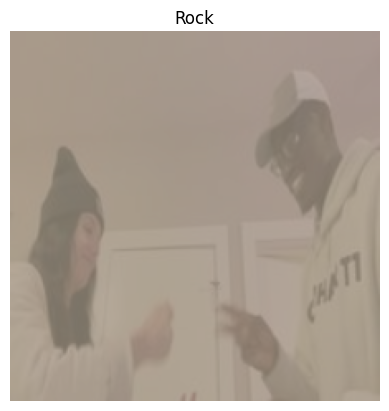

In [14]:
import torch
import matplotlib.pyplot as plt
import numpy as np

mean = torch.tensor([0.485, 0.456, 0.406])
std = torch.tensor([0.229, 0.224, 0.225])

def imshow(img_tensor, title=None):
    # Unnormalize
    img = img_tensor.clone()
    for c in range(3):
        img[c] = img[c] * std[c] + mean[c]

    img = img.numpy().transpose((1, 2, 0))  # CHW to HWC
    img = np.clip(img, 0, 1)  # Clip to valid range for display

    plt.imshow(img)
    if title:
        plt.title(title)
    plt.axis('off')
    plt.show()

# Then, get a batch from your dataloader and visualize:
images, labels = next(iter(dataloader))
class_names = ['Rock', 'Paper', 'Scissors']

for i in range(min(4, len(images))):
    imshow(images[i], title=class_names[labels[i]])


Creating a module to refer back to

In [14]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image

class RockPaperScissorsDataset(Dataset):
    def __init__(self, dataframe, img_dir, class_to_idx, transform=None):
        self.dataframe = dataframe
        self.img_dir = img_dir
        self.class_to_idx = class_to_idx
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        img_path = os.path.join(self.img_dir, row['filename'])
        image = Image.open(img_path).convert("RGB")
        label = self.class_to_idx[row['class']]
        if self.transform:
            image = self.transform(image)
        return image, label

def subsample_dataframe(df, n_per_class=100, random_state=42):
    return df.groupby('class').apply(lambda x: x.sample(min(len(x), n_per_class), random_state=random_state)).reset_index(drop=True)

def create_dataloader(dataframe, img_dir, class_names, batch_size=16, transform=None, shuffle=True, num_workers=0):
    class_to_idx = {cls: idx for idx, cls in enumerate(class_names)}
    dataset = RockPaperScissorsDataset(dataframe, img_dir, class_to_idx, transform=transform)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers)
    return dataloader


In [23]:
#examples

#from data_loader_module import subsample_dataframe, create_dataloader

# Subsample your cleaned DataFrame (e.g., df_train_clean)
#train_subset = subsample_dataframe(df_train_clean, n_per_class=100)

# Define transforms (e.g., resizing, normalization)
#from torchvision import transforms
#transform = transforms.Compose([
#   transforms.Resize((224, 224)),
#    transforms.ToTensor(),
#])

# Create DataLoader
#train_loader = create_dataloader(train_subset, img_dir="rock-paper-scissors/train/train/", class_names=['Rock', 'Paper', 'Scissors'], batch_size=16, transform=transform)


In [ ]:
# from data_utils import RockPaperScissorsDataset, create_dataloader


Data Augmentation

In [15]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define your data augmentation parameters for the training set
train_datagen = ImageDataGenerator(
    rescale=1./255,              # Normalizes pixel values
    rotation_range=30,           # Random rotations up to 30 degrees
    width_shift_range=0.2,       # Horizontal shifts
    height_shift_range=0.2,      # Vertical shifts
    shear_range=0.2,             # Shearing transformations
    zoom_range=0.2,              # Random zooms
    horizontal_flip=True,        # Random horizontal flip
    fill_mode='nearest'          # Filling strategy for new pixels
)

# For validation and/or test: Only rescaling, no augmentation!
val_datagen = ImageDataGenerator(rescale=1./255)


In [16]:
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_subset,                   # Your cleaned, balanced training DataFrame
    directory="rock-paper-scissors/train/train/",  # Directory containing image files
    x_col="filename",                         # DataFrame column with image file names
    y_col="class",                            # DataFrame column with class labels
    target_size=(224, 224),                   # Replace with the size your model expects
    batch_size=32,
    class_mode="categorical"                  # For multi-class classification
)

val_generator = val_datagen.flow_from_dataframe(
    dataframe=test_subset,                    # Your DataFrame for validation or test
    directory="rock-paper-scissors/test/test/",
    x_col="filename",
    y_col="class",
    target_size=(224, 224),
    batch_size=32,
    class_mode="categorical",
    shuffle=False
)


Found 300 validated image filenames belonging to 3 classes.
Found 204 validated image filenames belonging to 3 classes.


Checking to see what augmented images look like

Found 300 validated image filenames belonging to 3 classes.


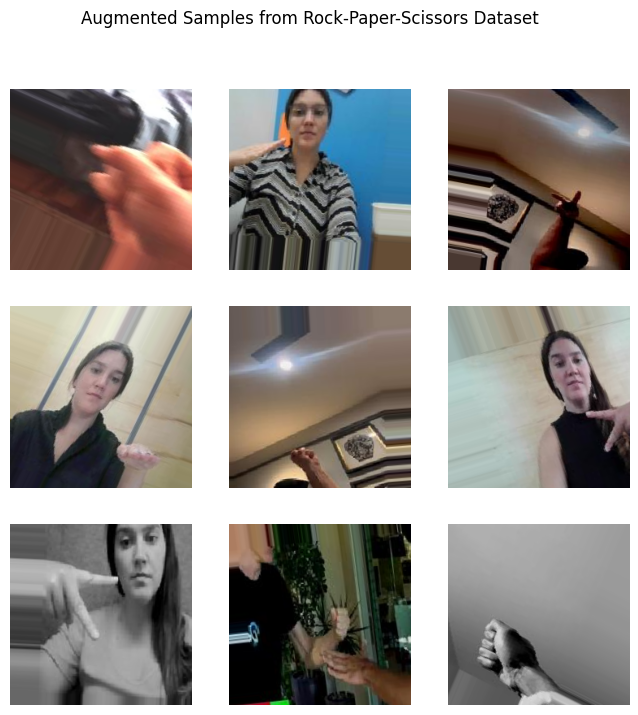

In [19]:
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define your data augmentation like before
train_datagen = ImageDataGenerator(
    rescale=1./255,            
    rotation_range=30,         
    width_shift_range=0.2,     
    height_shift_range=0.2,    
    shear_range=0.2,           
    zoom_range=0.2,            
    horizontal_flip=True,      
    fill_mode='nearest'        
)

# Create a generator from your dataframe and directory
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_subset,                   
    directory="rock-paper-scissors/train/train/",  
    x_col="filename",                         
    y_col="class",                            
    target_size=(224, 224),                   
    batch_size=9,                            # To show a 3x3 grid of images
    class_mode="categorical",
    shuffle=True
)

# Fetch one batch of images and labels
images, labels = next(train_generator)

# Plot the images in a 3x3 grid
plt.figure(figsize=(8, 8))
for i in range(len(images)):
    plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])
    plt.axis('off')
plt.suptitle("Augmented Samples from Rock-Paper-Scissors Dataset")
plt.show()


Checking to see if images are standard size

In [17]:
from PIL import Image

img_path = 'rock-paper-scissors/train/train/egohands-public-1620914960773_png_jpg.rf.aa184eeebad98b2fb04354d01a90b9d0.jpg'
img = Image.open(img_path)

width, height = img.size
print(f"Image size: {width}x{height}")

mode = img.mode
print(f"Image mode (color channels): {mode}")

# Check if size is 180x180
if (width, height) == (180, 180):
    print("Image is standard size 180x180.")
else:
    print("Image is NOT the standard size 180x180.")

# Check if RGB
if mode == 'RGB':
    print("Image has 3 RGB channels.")
else:
    print(f"Image has different color mode: {mode}")


Image size: 180x180
Image mode (color channels): RGB
Image is standard size 180x180.
Image has 3 RGB channels.


Resizing images to standard 180x180 (ONLY HAVE TO RUN ONCE)

In [67]:
#import os
#from PIL import Image

#img_dir = "rock-paper-scissors/train/train/"  # Your image folder

#for filename in os.listdir(img_dir):
#    if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
 #       path = os.path.join(img_dir, filename)
  #      with Image.open(path) as img:
   #         if img.size != (180, 180):  # Only resize if not already 180x180
    #            img_resized = img.resize((180, 180), Image.LANCZOS)
     #           img_resized.save(path)  # Overwrite the original file
      #          print(f"Resized {filename} to 180x180")
       #     else:
        #        print(f"{filename} already 180x180")


Resized posada_14_15_altavista_jpg.rf.b8860c1615ebcac87d0e4e75712a3da2.jpg to 180x180
Resized Screen-Recording-2023-03-11-at-9_48_18-PM_mov-280_jpg.rf.80740f62dec314ac705bfe5c605e8338.jpg to 180x180
Resized egohands-public-1622127401153_png_jpg.rf.b9fa33712263a323f94a8a7c549bdb99.jpg to 180x180
Resized egohands-public-1622127403072_png_jpg.rf.eefac375eff15d9c47d10b3ea22ed6a3.jpg to 180x180
Resized zoom_tests_RockPaperScissors-mohamed_mp4-128_jpg.rf.c2b896a6fd0c2a9b550d15291e85747d.jpg to 180x180
Resized Screen-Recording-2023-03-11-at-9_48_18-PM_mov-305_jpg.rf.4ba4faca77a02ceb81339df555796c63.jpg to 180x180
Resized youtube-142_jpg.rf.289c5442d5f3c1a7022caf201a4a3c41.jpg to 180x180
Resized zoom_tests_RockPaperScissors-mohamed_mp4-197_jpg.rf.6213139a3a8fd406b45066c01c3dc5af.jpg to 180x180
Resized PUZZLE_COURTYARD_T_H_frame_0260_jpg.rf.ef3dcf8cf1477a671e5e4566ff407b9f.jpg to 180x180
Resized egohands-public-1625679151324_png_jpg.rf.60b15b0d1b428ce13d38b85bfd7ffb5b.jpg to 180x180
Resized Scr

**Preprocessing time**

Define augmentation and Normalization for training

In [18]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1./255,              # Normalize pixel values to [0,1]
    rotation_range=30,           # Rotate images randomly ±30 degrees
    width_shift_range=0.2,       # Horizontally shift images up to 20%
    height_shift_range=0.2,      # Vertically shift images up to 20%
    shear_range=0.2,             # Shear transformations
    zoom_range=0.2,              # Zoom in/out randomly
    horizontal_flip=True,        # Flip images horizontally
    fill_mode='nearest'          # Fill in missing pixels after transformations
)


In [19]:
#preparing separate generator for tests

val_datagen = ImageDataGenerator(rescale=1./255)

Using dataframe to connect dataframe

In [20]:
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_subset,
    directory="rock-paper-scissors/train/train/",  # Your training images folder
    x_col="filename",    # CSV column with filenames
    y_col="class",       # CSV column with class labels (e.g., 'Rock', 'Paper', 'Scissors')
    target_size=(180, 180),  # Resize images to CNN input size (standardized)
    batch_size=32,
    class_mode="categorical",  # For multi-class classification
    shuffle=True
)

val_generator = val_datagen.flow_from_dataframe(
    dataframe=test_subset,
    directory="rock-paper-scissors/test/test/",
    x_col="filename",
    y_col="class",
    target_size=(180, 180),
    batch_size=32,
    class_mode="categorical",
    shuffle=False   # Usually no shuffle for validation
)


Found 300 validated image filenames belonging to 3 classes.
Found 204 validated image filenames belonging to 3 classes.
